In [1]:
import pytesseract
from PIL import Image
import google.generativeai as genai
import json
import matplotlib.pyplot as plt
import re
import cv2 as cv

c:\Users\swara\anaconda3\envs\bajaj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)
    height, width  = im_data.shape[:2]
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(im_data, cmap='gray')
    plt.show()

In [3]:
def extract_text_from_image(image_path):
    img = Image.open(image_path)
    text = pytesseract.image_to_string(img, lang='eng')
    return text

In [8]:
def structure_with_gemini(extracted_text, api_key):
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-2.5-flash')

    prompt = f"""
    You are an expert invoice data extraction system. Analyze the following raw invoice text.
    Your task is to extract all line-item details, calculate the total item count, and
    determine the final reconciled amount (sum of all item_amount values).

    **INSTRUCTIONS:**
    1.  Assume the entire text belongs to 'page_no': '1'.
    2.  Extract the item name (Particulars), quantity (Qty.), rate (Rate), and amount (Amount)
        for every line item in the bill's table. If quantity or rate are not mentioned, use 0.0
    3.  Set 'total_item_count' to the count of unique line items found.
    4.  Set 'reconciled_amount' to the sum of all extracted 'item_amount' values.
    5.  The final output MUST strictly adhere to the provided JSON schema.
    6.  Include a 'token_usage' object with 'total_tokens', 'input_tokens', and 'output_tokens'.

    **REQUIRED JSON SCHEMA:**
    The final output must be a single JSON object (the response body for the API):
    {{
      "is_success": true,
      "data": {{
        "pagewise_line_items": [
          {{
            "page_no": "1",
            "bill_items": [
              {{
                "item_name": "...",
                "item_amount": 0.00,
                "item_rate": 0.00,
                "item_quantity": 0.00
              }}
              // ... continue for all line items
            ]
          }}
        ],
        "total_item_count": 0,
        "reconciled_amount": 0.00,
        "token_usage": {{
          "total_tokens": 0,
          "input_tokens": 0,
          "output_tokens": 0
        }}
      }}
    }}

    Invoice text:
    ---
    {extracted_text}
    ---

    Return ONLY the valid JSON object, without any surrounding markdown, backticks, or explanation. The output should strictly not contain any characters that are not part of the json syntax
    """



    response = model.generate_content(prompt)
    return response


In [12]:
from dotenv import load_dotenv
import os
load_dotenv()
api_key = os.getenv("API_KEY")

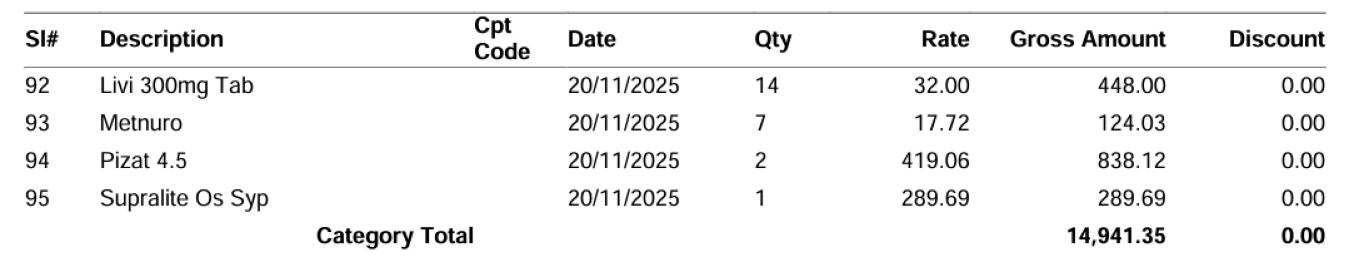

In [9]:
image_path = "sample_data/sample_2.png"
extracted_text = extract_text_from_image(image_path)
display(image_path)

In [15]:
print(extracted_text)

Cpt

Sl# Description Code Date Qty Rate Gross Amount Discount
92 Livi 300mg Tab 20/11/2025 14 32.00 448.00 0.00
93 Metnuro 20/11/2025 7 17.72 124.03 0.00
94 Pizat 4.5 20/11/2025 2 419.06 838.12 0.00
95 Supralite Os Syp 20/11/2025 1 289.69 289.69 0.00

Category Total 14,941.35 0.00



In [29]:
def format_response(response):
    candidate = response.candidates[0]
    content = candidate.content
    raw_json_string = content.parts[0].text
    cleaned_json_string = re.sub(r'```json|```', '', raw_json_string, flags=re.IGNORECASE).strip()
    final_json_data = json.loads(cleaned_json_string)
    return json.dumps(final_json_data)  # Return formatted JSON string

In [30]:
response = structure_with_gemini(extracted_text, api_key)
output = format_response(response)
output

'{"is_success": true, "data": {"pagewise_line_items": [{"page_no": "1", "bill_items": [{"item_name": "Livi 300mg Tab", "item_amount": 448.0, "item_rate": 32.0, "item_quantity": 14.0}, {"item_name": "Metnuro", "item_amount": 124.03, "item_rate": 17.72, "item_quantity": 7.0}, {"item_name": "Pizat 4.5", "item_amount": 838.12, "item_rate": 419.06, "item_quantity": 2.0}, {"item_name": "Supralite Os Syp", "item_amount": 289.69, "item_rate": 289.69, "item_quantity": 1.0}]}], "total_item_count": 4, "reconciled_amount": 1799.84, "token_usage": {"total_tokens": 0, "input_tokens": 0, "output_tokens": 0}}}'

In [28]:
type(output)

str